In [18]:
%pip install numpy
%pip install matplotlib
%pip install scipy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../")

from softpy.fuzzy.fuzzyset import *
from softpy.fuzzy.operations import *
from softpy.fuzzy.fuzzy_control import *
from softpy.fuzzy.knowledge_base import *
from softpy.fuzzy.fuzzy_partition import *
from softpy.fuzzy.fuzzy_rule import *

In [20]:
def outside_temperature(start_temp, days=1):
    temps = []
    temp = start_temp
    for d in range(days):
        for time in range(6):
            temps.append(temp)
            temp -= 1

        for time in range(6,9):
            temps.append(temp)
            temp += 0.67

        for time in range(9,15):
            temps.append(temp)
            temp += 1.67

        for time in range(15, 18):
            temps.append(temp)
            temp += 0.33

        for time in range(18,24):
            temps.append(temp)
            temp -= 1.17


    return temps

In [21]:
def inhouse_temperature(in_t_prev, out_t_curr, control):
    in_t_curr = in_t_prev
    in_t_curr = (out_t_curr + in_t_prev)/2
    return in_t_curr + control

In [22]:
def error(temps):
    err = 0
    for i in temps:
        if i < 18:
            err += 18 - i
        elif i > 24:
            err += i - 24
    return err/len(temps)

In [23]:
in_t_noc = []
in_t_noc.append(18)
out_t = outside_temperature(18, 5)

for t in range(1,24*5):
    in_t_noc.append(inhouse_temperature(in_t_noc[t-1], out_t[t], 0))

(0.0, 36.0)

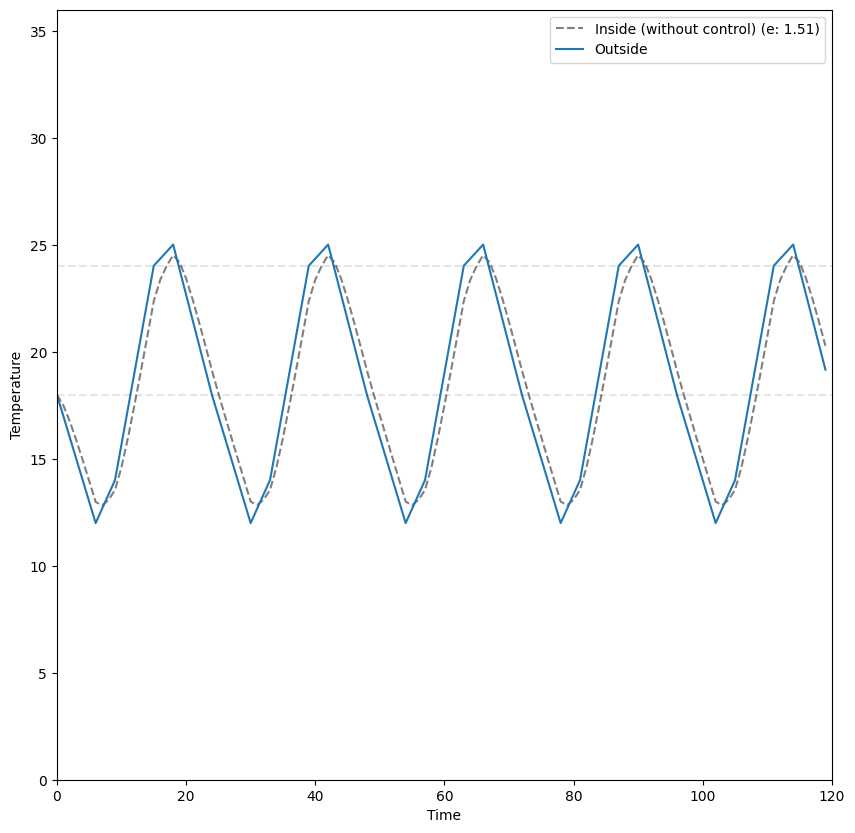

In [24]:
plt.figure(figsize=(10,10))

plt.plot(in_t_noc, label="Inside (without control) (e: %.2f)" % error(in_t_noc), c="k", ls='--', alpha=0.5)
plt.plot(out_t, label="Outside")

plt.axhline(y=18, color='k', linestyle='--', alpha=0.1)
plt.axhline(y=24, color='k', linestyle='--', alpha=0.1)


plt.legend()

plt.xlabel("Time")
plt.ylabel("Temperature")
plt.xlim(0,24*5)
plt.ylim(0,36)

In [25]:
temperature_partition = FuzzyPartition('temperature', {
    'low': LinearZFuzzySet(12, 18, bound=(0, 40)),
    'medium': TrapezoidalFuzzySet(18, 20, 22, 24, bound=(0, 40)),
    'high': LinearSFuzzySet(26, 40, bound=(0, 40)),
})

controller_partition = FuzzyPartition('controller', {
    'low': LinearSFuzzySet(-2,-1, bound=(-2, 2)),
    'low-medium': TrapezoidalFuzzySet(-1.5, -1, -0.5, 0, bound=(-2, 2)),
    'nochange': TriangularFuzzySet(-0.1, 0, 0.1, bound=(-2, 2)),
    'high-medium': TrapezoidalFuzzySet(0, 0.5, 1, 1.5, bound=(-2, 2)),
    'high': LinearZFuzzySet(1,2, bound=(-2, 2)),
})


(-0.01, 1.01)

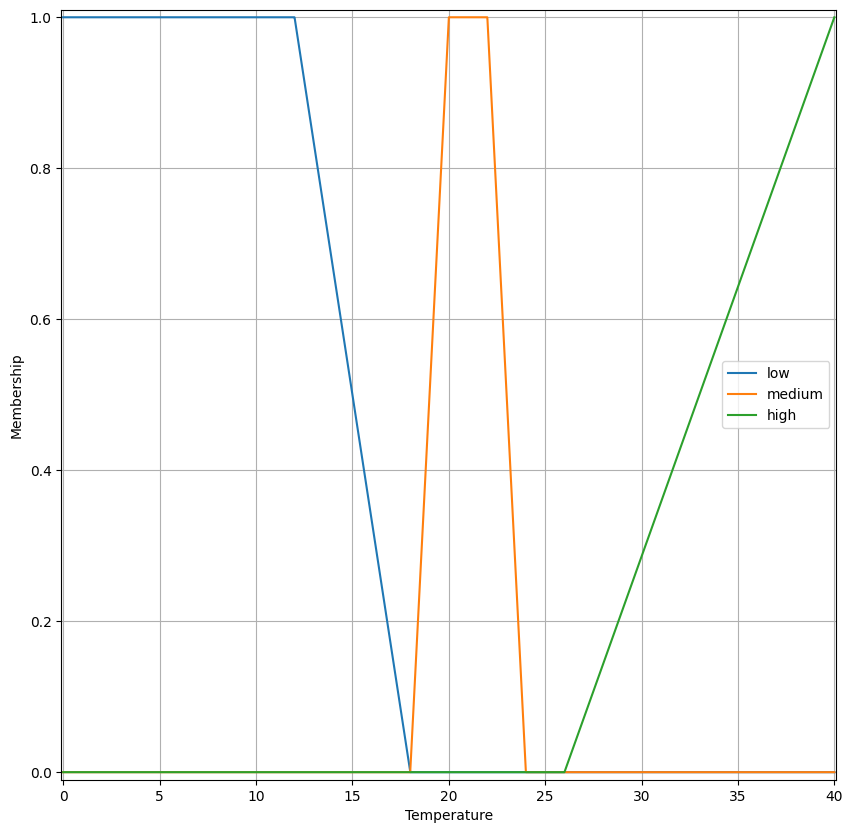

In [26]:
xs = np.linspace(0, 40, int(41 / 1e-2))

plt.figure(figsize=(10,10))

for name in temperature_partition.get_fuzzy_set_names():
    l = [temperature_partition[name](v) for v in xs]
    plt.plot(xs, l, label=name)
    
plt.legend()

plt.xlabel("Temperature")
plt.ylabel("Membership")
plt.grid()
plt.xlim(-0.1, 40.1)
plt.ylim(-0.01,1.01)

(-0.01, 1.01)

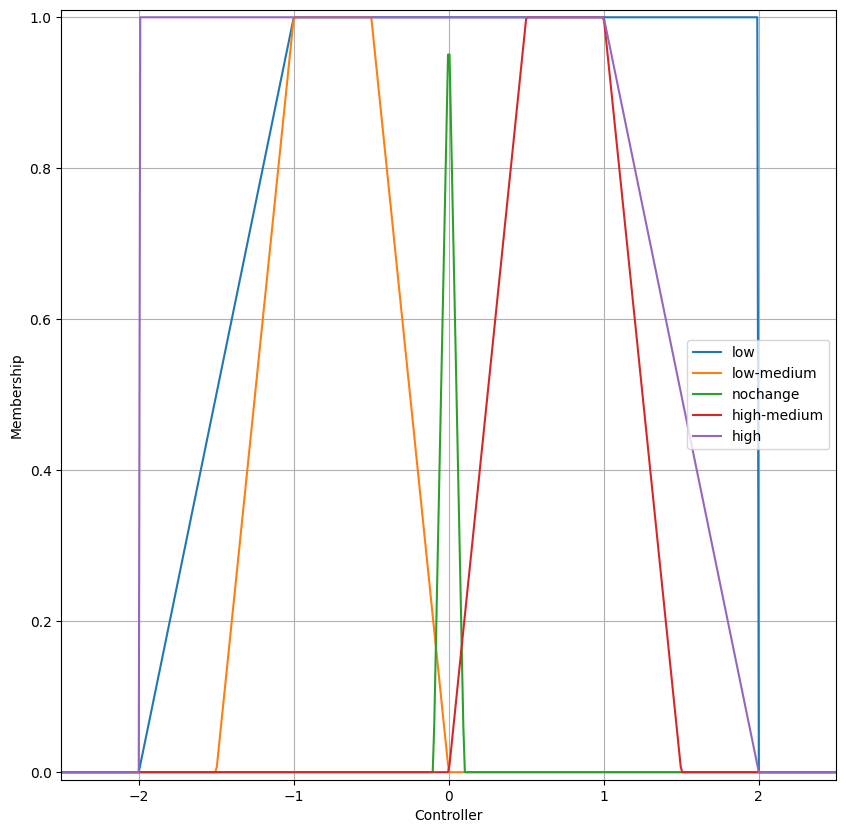

In [27]:
xs = np.linspace(-40, 40, int(81 / 1e-2))

plt.figure(figsize=(10,10))

for name in controller_partition.get_fuzzy_set_names():
    l = [controller_partition[name](v) for v in xs]
    plt.plot(xs, l, label=name)
    
plt.legend()

plt.xlabel("Controller")
plt.ylabel("Membership")
plt.grid()
plt.xlim(-2.5, 2.5)
plt.ylim(-0.01,1.01)

In [28]:
rules = [
    MamdaniRule({temperature_partition.name: [temperature_partition['low']]},
                controller_partition.name,
                controller_partition['high']),
    MamdaniRule({temperature_partition.name: [temperature_partition['low'],
                                              temperature_partition['medium']]},
                 controller_partition.name,
                 controller_partition['high-medium']),
    MamdaniRule({temperature_partition.name: [temperature_partition['medium']]},
                controller_partition.name,
                controller_partition['nochange']),
    MamdaniRule({temperature_partition.name: [temperature_partition['medium'],
                                              temperature_partition['high']]},
                 controller_partition.name,
                 controller_partition['low-medium']),
    MamdaniRule({temperature_partition.name: [temperature_partition['high']]},
                controller_partition.name,
                controller_partition['low']),
]

kb = MamdaniKnowledgeBase(rules, AggregationType.FITA)
RBController = ControlSystem(kb)

in_t = []
in_t.append(18)
in_t_noc = []
in_t_noc.append(18)
out_t = outside_temperature(18, 5)
ccnt = []
output_fuzzy_sets = {}

for t in range(1,24*5):
        cnt = RBController.evaluate({temperature_partition.name: in_t[t-1]})
        ccnt.append(cnt[controller_partition.name])
        in_t.append(inhouse_temperature(in_t[t-1], out_t[t], cnt[controller_partition.name]))
        in_t_noc.append(inhouse_temperature(in_t_noc[t-1], out_t[t], 0))
print(in_t)
print(in_t_noc)
print(ccnt)


[18, 17.5, 16.75, 15.875, 14.9375, 13.96875, 12.984375, 12.8271875, 13.08359375, 13.546796875, 14.613398437499999, 15.98169921875, 17.500849609375003, 19.095424804687504, 20.727712402343755, 22.37885620117188, 23.369428100585942, 24.029714050292974, 24.52485702514649, 24.187428512573245, 23.43371425628662, 22.47185712814331, 21.40592856407165, 20.287964282035823, 19.143982141017908, 18.07199107050895, 17.03599553525447, 16.017997767627232, 15.008998883813613, 14.004499441906802, 13.002249720953397, 12.836124860476694, 13.088062430238343, 13.549031215119168, 14.61451560755958, 15.982257803779788, 17.501128901889892, 19.095564450944945, 20.727782225472474, 22.378891112736238, 23.36944555636812, 24.02972277818406, 24.524861389092028, 24.18743069454601, 23.433715347273, 22.471857673636496, 21.40592883681824, 20.287964418409114, 19.14398220920455, 18.07199110460227, 17.035995552301127, 16.01799777615056, 15.008998888075272, 14.004499444037629, 13.002249722018806, 12.836124861009395, 13.0880

(-10.0, 36.0)

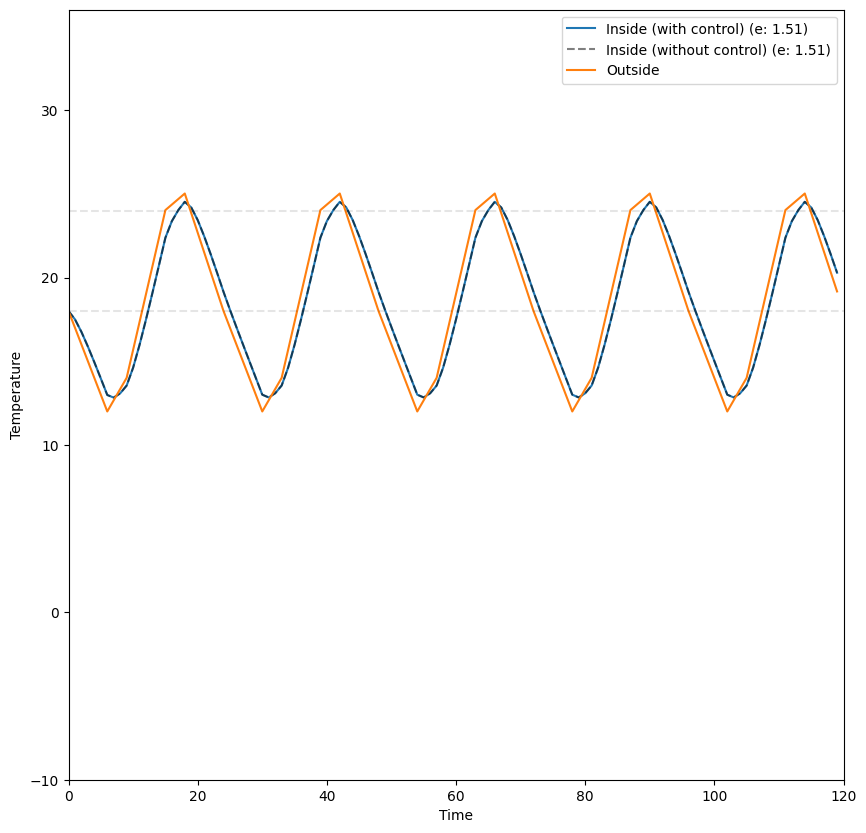

In [29]:
plt.figure(figsize=(10,10))
    
plt.plot(in_t, label="Inside (with control) (e: %.2f)" % error(in_t))
plt.plot(in_t_noc, label="Inside (without control) (e: %.2f)" % error(in_t_noc), c="k", ls='--', alpha=0.5)
plt.plot(out_t, label="Outside")

plt.axhline(y=18, color='k', linestyle='--', alpha=0.1)
plt.axhline(y=24, color='k', linestyle='--', alpha=0.1)


plt.legend()

plt.xlabel("Time")
plt.ylabel("Temperature")
plt.xlim(0,24*5)
plt.ylim(-10,36)

# TSK Controller

In [ ]:
temperature_partition = FuzzyPartition('temperature', {
    'low': LinearZFuzzySet(12, 18, bound=(0, 40)),
    'medium': TrapezoidalFuzzySet(16, 18, 24, 26, bound=(0, 40)),
    'high': LinearSFuzzySet(26, 40, bound=(0, 40)),
})

controller_partition = FuzzyPartition('controller', {
    'low': LinearSFuzzySet(-2,-1, bound=(-2, 2)),
    'low-medium': TrapezoidalFuzzySet(-1.5, -1, -0.5, 0, bound=(-2, 2)),
    'nochange': TriangularFuzzySet(-0.1, 0, 0.1, bound=(-2, 2)),
    'high-medium': TrapezoidalFuzzySet(0, 0.5, 1, 1.5, bound=(-2, 2)),
    'high': LinearZFuzzySet(1,2, bound=(-2, 2)),
})